Neural Networks for Time Series Prediction

MIE 1516 Final Project


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import newaxis
from operator import itemgetter
from IPython.display import display, HTML
from keras.layers import Dense, Activation, Dropout, LSTM, RepeatVector, TimeDistributed, Flatten, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, SGD
from data_processor import DataLoader
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor
import warnings

warnings.simplefilter('ignore')

Using TensorFlow backend.


In [0]:
# Global constants
DATA_FEATURES = ["Close","Volume","Open","High","Low"]
N_FEATURES = len(DATA_FEATURES)
TIME_WINDOW = 49
BATCH_SIZE = 32
GRID_SEARCH_METRICS = ['mean_test_score','std_test_score','mean_score_time'] 
OPTIMIZER_LIST = ['Adam', 'RMSprop', 'SGD']

In [0]:
# Load S&P 500 data
data = DataLoader(
    "sp500.csv",        # filename
    0.85,               # train/test split
    DATA_FEATURES       # column names
)

# Get train/test data
x_train, y_train = data.get_train_data(seq_len=50, normalise=True)
x_test, y_test = data.get_test_data(seq_len=50, normalise=True)


In [0]:
# Helper functions for graphs and tables
def plot_sp500_curves(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for p in predicted_data:
      plt.plot(predicted_data[p][0], label=p)
    plt.title('S&P 500 Closing Price Over Time')
    plt.ylabel('closing price')
    plt.xlabel('time (days)')
    plt.legend()
    plt.show()

def plot_train_loss(history, info):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(info)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #8FFC9C' if v else '' for v in is_min]

def show_table(df, col_names):
  # df = pd.DataFrame(data[1:], columns=data[0])
  df_html = df.style \
              .apply(highlight_min, axis=1, subset=pd.IndexSlice[:, col_names]) \
              .set_table_attributes('border="2" border-color="black" class="dataframe table table-hover table-bordered"') \
              .set_precision(5) \
              .render()
  display(HTML(df_html))

def show_grid_search_results(df, param):
  param_col = ['param_'+p for p in param]
  df_filt = df[param_col+GRID_SEARCH_METRICS]
  df_filt['mean_test_score'] = df_filt['mean_test_score'].abs()
  if (len(param_col)==1):
    df_filt.plot(x=param_col[0], y='mean_test_score', kind='bar')
  else:
    df_plt = df_filt.set_index(param_col).mean_test_score
    df_plt.unstack().plot(kind='bar')
  return df_filt  

# Get summary metrics and plot for whatever property is being modified
def get_performance_summary(results, variations):
  # Plot S&P predictions
  plot_sp500_curves(results, y_test)

  # Metric table
  rmse = ['RMSE']
  mape = ['MAPE']
  t = ['Time (min)']
  for r in results:
    rmse.append(results[r][1])
    mape.append(results[r][2])
    t.append(results[r][3]/60)

  tbl = [['Metric']+variations]
  tbl.append(rmse)
  tbl.append(mape)
  tbl.append(t)
  # show_table(tbl, variations)
  show_table(pd.DataFrame(tbl[1:], columns=tbl[0]), variations)

In [0]:
# Helper functions for model building/testing
def get_predictions(model, x):
  predicted = model.predict(x)
  return np.reshape(predicted, (predicted.size,1))

def calculate_error(pred, target):
  rmse = np.sqrt(((pred - target) ** 2).mean())
  mape = np.mean(np.abs((target - pred) / target)) * 100
  print('RMSE = %f, MAPE = %f ' % (rmse, mape))
  return [rmse, mape]

## Original Architecture (Baseline)

Establish baseline model for comparison with new architectures.

1. Determine best learning rate for each optimizer.

2. Evaluate performance of each optimizer using best learning rates.

In [0]:
# Constants
N_EPOCHS = 100
LEARNING_RATES = [1e-2, 1e-3, 1e-4, 1e-5]

### 1. Determine best learning rate for each optimizer.

In [0]:
# Original (Baseline) LSTM architecture
def build_baseline_model_lr(optimizer, learning_rate):
  m = Sequential()
  m.add(LSTM(100, input_shape=(TIME_WINDOW, N_FEATURES), return_sequences=True))
  m.add(Dropout(0.2))
  m.add(LSTM(100, return_sequences=True))
  m.add(LSTM(100, return_sequences=False))
  m.add(Dropout(0.2))
  m.add(Dense(1, activation="linear"))

  opt=get_optimizer(optimizer, learning_rate)
  m.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
  return m

In [0]:
# Helper functions

# Optimizers
def get_optimizer(name, lr):
  optimizer = None
  if (name == 'Adam'):
    optimizer = Adam(lr=lr)
  if (name == 'RMSprop'):
    optimizer = RMSprop(lr=lr)
  if (name == 'SGD'):
    optimizer = SGD(lr=lr)
  return optimizer

# Train model with various learning rates
def train_baseline_lr(opt, lr):
  lstm = build_baseline_model_lr(opt, lr)
  print('[Model] Training Started')
  print('[Model] %s epochs, %s batch size' % (N_EPOCHS, BATCH_SIZE))
  start_time = time.time()
  history = model.fit(x_train, y_train,
        validation_data=(x_test, y_test), 
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
      )
  end_time = time.time()
  print('[Model] Training Completed')
  plot_train_loss(history, " Opt="+opt+" LR="+opt)

In [0]:
# Grid search
start_time = time.time()
# Create model
model = KerasRegressor(build_fn=build_baseline_model_lr, epochs=50, batch_size=BATCH_SIZE, verbose=1)
# Grid search parameters
param_grid = dict(optimizer=OPTIMIZER_LIST, learning_rate=LEARNING_RATES)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='neg_mean_squared_error', 
                    cv=TimeSeriesSplit(n_splits=5)
                    )
results = grid.fit(x_train, y_train)
end_time = time.time()
print("Grid search time: %f min" % ((end_time-start_time)/60))

In [0]:
show_grid_search_results(pd.DataFrame(results.cv_results_),['optimizer','learning_rate']).sort_values('param_optimizer')

In [0]:
# Get train/test loss curve for each optimizer & learning rate
for opt in OPTIMIZER_LIST:
  for lr in LEARNING_RATES:
    train_baseline_lr(opt, lr) 

In [0]:
# Grid search for RMSProp only
start_time = time.time()
# Create model
model = KerasRegressor(build_fn=build_baseline_model_lr, epochs=100, batch_size=BATCH_SIZE, verbose=1)
# Grid search parameters
param_grid = dict(optimizer=['RMSprop'], learning_rate=LEARNING_RATES)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring='neg_mean_squared_error', 
                    cv=TimeSeriesSplit(n_splits=5)
                    )
results = grid.fit(x_train, y_train)
end_time = time.time()
print("Grid search time: %f min" % ((end_time-start_time)/60))

,param_optimizer,param_learning_rate,mean_test_score,std_test_score,mean_score_time
0,RMSprop,0.01,0.001024,0.000788,1.350635
1,RMSprop,0.001,0.000199,0.000184,1.672123
2,RMSprop,0.0001,0.000195,0.000120,1.926943
3,RMSprop,1e-05,0.000486,0.000336,2.413277


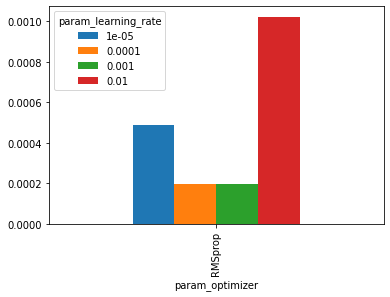

In [0]:
# Show grid search results for RMSProp only
show_grid_search_results(pd.DataFrame(results.cv_results_),['optimizer','learning_rate']).sort_values('param_optimizer')

### 2. Evaluate performance of each optimizer using best learning rates.

In [0]:
# Based on results from each learning rate, 
# use best learning rate for each optimizer
def get_best_optimizer(name):
  optimizer = None
  if (name == 'Adam'):
    optimizer = Adam(lr=0.001)
  if (name == 'RMSprop'):
    optimizer = RMSprop(lr=0.0001)
  if (name == 'SGD'):
    optimizer = SGD(lr=0.01)
  return optimizer

# Original (Baseline) LSTM architecture with optimal learning rates
def build_baseline_model(optimizer='Adam'):
  m = Sequential()
  m.add(LSTM(100, input_shape=(TIME_WINDOW, N_FEATURES), return_sequences=True))
  m.add(Dropout(0.2))
  m.add(LSTM(100, return_sequences=True))
  m.add(LSTM(100, return_sequences=False))
  m.add(Dropout(0.2))
  m.add(Dense(1, activation="linear"))

  opt=get_best_optimizer(optimizer)
  m.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
  return m

# Train model
def train_baseline(opt):
  lstm = build_baseline_model(opt)
  print('[Model] Training Started')
  print('[Model] %s epochs, %s batch size' % (N_EPOCHS, BATCH_SIZE))
  start_time = time.time()
  history = model.fit(x_train, y_train,
        validation_data=(x_test, y_test), 
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
      )
  end_time = time.time()
  print('[Model] Training Completed')
  plot_train_loss(history, " Opt="+opt)

  # Get predictions
  pred = get_predictions(lstm, x_test)
  err = calculate_error(pred, y_test)
  return [pred, err[0], err[1], end_time-start_time]

In [0]:
# Get predictions for each optimizer
results = {}
for opt in OPTIMIZER_LIST:
  results[opt] = train_baseline(opt)

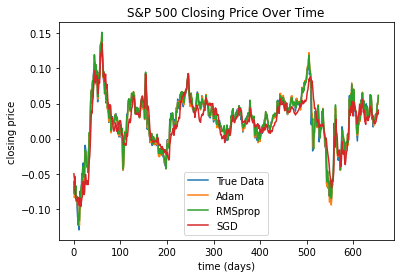

,Metric,Adam,RMSprop,SGD
0,RMSE,0.00738,0.00765,0.0165
1,MAPE,36.8,43.1,100
2,Time (min),35.6,35.6,35.2


In [0]:
get_performance_summary(results, OPTIMIZER_LIST)

## LSTM Autoencoder

1. Implement shallow architecture (two LSTM layers).
  
  a. Determine optimal number of neurons for LSTM hidden layers.

  b. Evaluate performance of each optimizer for best number of neurons.

2. Implement deep architecture (four LSTM layers).
  
  a. Determine optimal number of neurons for LSTM hidden layers.

  b. Evaluate performance of each optimizer for best number of neurons.

In [0]:
# Helper functions
def get_ae_predictions(model, x):
  predicted = model.predict(x)
  return np.reshape(predicted[:,-1,0], (predicted[:,-1,0].size,1))

### 1. Implement shallow architecture

In [0]:
# Constants
NEURONS_LIST = [25, 50, 75, 100]
N_EPOCHS = 100

In [0]:
# Helper functions

# Build model
def build_shallow_lstm_ae(optimizer, neurons):
  m = Sequential()
  m.add(LSTM(neurons, input_shape=(TIME_WINDOW, N_FEATURES), return_sequences=False))
  m.add(Dropout(0.2))
  m.add(RepeatVector(TIME_WINDOW))
  m.add(LSTM(neurons, return_sequences=True))
  m.add(Dropout(0.2))
  m.add(TimeDistributed(Dense(N_FEATURES, activation="linear")))
  
  opt=get_best_optimizer(optimizer)
  m.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
  return m

# Train model
def train_shallow_lstm_ae(opt, neurons):
  lstm_ae = build_shallow_lstm_ae(opt, neurons)
  print('[Model] Training Started')
  print('[Model] %s epochs, %s batch size' % (N_EPOCHS, BATCH_SIZE))
  start_time = time.time()
  history = lstm_ae.fit(x_train, x_train,
        validation_data=(x_test, x_test), 
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
      )
  end_time = time.time()
  print('[Model] Training Completed')
  plot_train_loss(history, " Opt="+opt+" Neurons="+str(neurons))

  # Get predictions
  pred = get_ae_predictions(lstm_ae, x_test)
  err = calculate_error(pred, y_test)
  return [pred, err[0], err[1], end_time-start_time]

#### 1.a. Determine optimal number of neurons for LSTM layer. Only Adam optimizer is used.

In [0]:
# Grid search
start_time = time.time()
# Create model
model = KerasRegressor(build_fn=build_shallow_lstm_ae, optimizer='Adam', epochs=100, batch_size=BATCH_SIZE, verbose=1)
# Grid search parameters
param_grid = dict(neurons=NEURONS_LIST)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=TimeSeriesSplit(n_splits=5)
                    )
nsamples, nx, ny = x_train.shape
d2_train_dataset = x_train.reshape((nsamples,nx*ny))
results = grid.fit(x_train, x_train)
end_time = time.time()

print("Grid search time: %f min" % ((end_time-start_time)/60))

,param_neurons,mean_test_score,std_test_score,mean_score_time
0,25,0.006393,0.001776,8.383675
1,50,0.005939,0.001654,9.355790
2,75,0.005489,0.001387,9.994865
3,100,0.005584,0.001884,11.012161


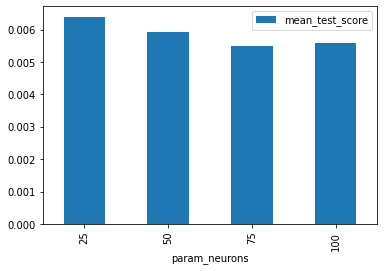

In [0]:
show_grid_search_results(pd.DataFrame(results.cv_results_),['neurons'])

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


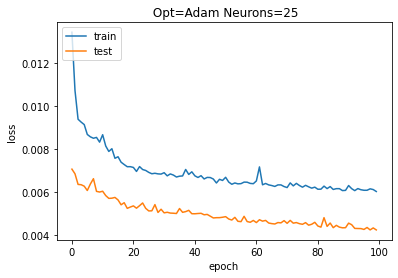

RMSE = 0.019230, MAPE = 105.320782, RMSE2 = 0.019230 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


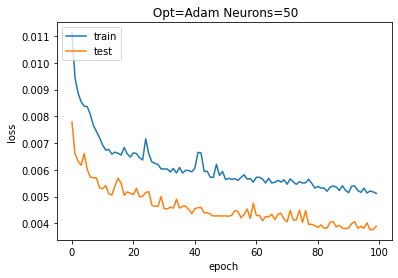

RMSE = 0.022097, MAPE = 102.534831, RMSE2 = 0.022097 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


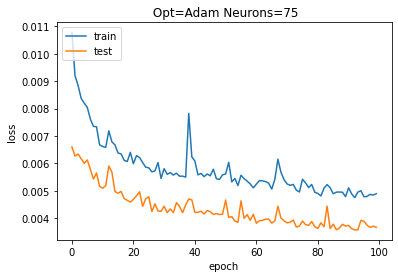

RMSE = 0.015654, MAPE = 91.979615, RMSE2 = 0.015654 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


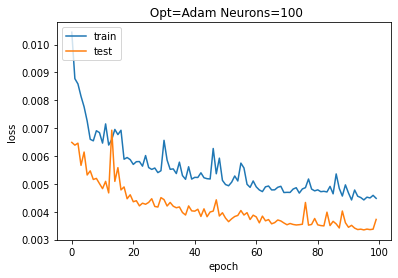

RMSE = 0.018939, MAPE = 100.170819, RMSE2 = 0.018939 


In [0]:
# Using NEURONS_LIST = [25, 50, 75, 100]
results = {}
for n in NEURONS_LIST:
  results[n] = train_shallow_lstm_ae('Adam', n)

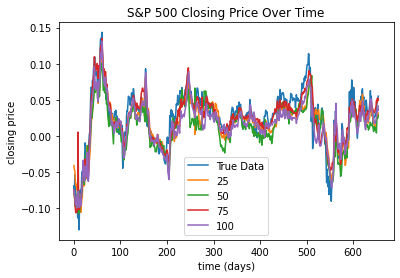

,Metric,25,50,75,100
0,RMSE,0.0192,0.0221,0.0157,0.0189
1,MAPE,105,103,92,100
2,Time (min),13.8,15.8,19.6,24.4


In [0]:
get_performance_summary(results, NEURONS_LIST)

#### 1. b. Evaluate performance of each optimizer for best number of neurons.

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


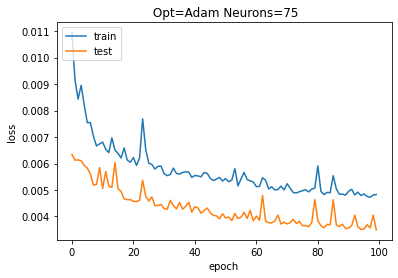

RMSE = 0.015416, MAPE = 83.060406 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


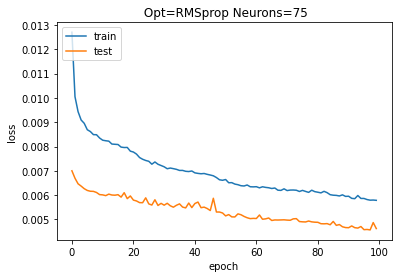

RMSE = 0.019250, MAPE = 107.019892 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


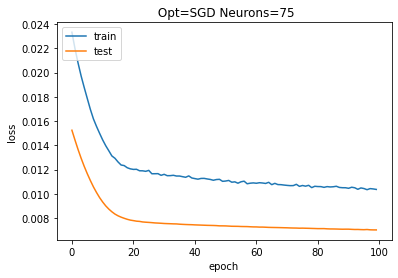

RMSE = 0.022746, MAPE = 78.831101 


In [0]:
results = {}
for opt in OPTIMIZER_LIST:
  results[opt] = train_shallow_lstm_ae(opt, 75)

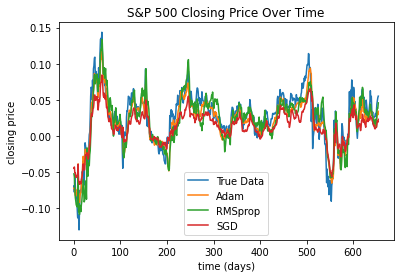

,Metric,Adam,RMSprop,SGD
0,RMSE,0.01542,0.01925,0.02275
1,MAPE,83.06041,107.01989,78.83110
2,Time (min),18.63086,18.20436,17.97906


In [0]:
get_performance_summary(results, OPTIMIZER_LIST)

### 2. Implement deep architecture

In [0]:
# Constants
NEURONS_LIST = [25, 50, 75]
N_EPOCHS = 100

In [0]:
# Helper functions

def build_deep_lstm_ae(optimizer, neurons):
  m = Sequential()
  m.add(LSTM(100, input_shape=(TIME_WINDOW, N_FEATURES), return_sequences=True))
  m.add(Dropout(0.2))
  m.add(LSTM(neurons, return_sequences=False))
  m.add(RepeatVector(TIME_WINDOW))
  m.add(LSTM(neurons, return_sequences=True))
  m.add(LSTM(100, return_sequences=True))
  m.add(Dropout(0.2))
  m.add(TimeDistributed(Dense(N_FEATURES, activation="linear")))
  
  opt=get_best_optimizer(optimizer)
  m.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
  return m

# Train model
def train_deep_lstm_ae(opt, neurons, add_dropout=False):
  lstm_ae = build_deep_lstm_ae(opt, neurons)
  print('[Model] Training Started')
  print('[Model] %s epochs, %s batch size' % (N_EPOCHS, BATCH_SIZE))
  start_time = time.time()
  history = lstm_ae.fit(x_train, x_train,
        validation_data=(x_test, x_test), 
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
      )
  end_time = time.time()
  print('[Model] Training Completed')
  plot_train_loss(history, " Opt="+opt+" Neurons="+str(neurons))

  # Get predictions
  pred = get_ae_predictions(lstm_ae, x_test)
  err = calculate_error(pred, y_test)
  return [pred, err[0], err[1], end_time-start_time]

#### 2.a. Determine optimal number of neurons for LSTM layer. Only Adam optimizer is used.

In [0]:
# Grid search

start_time = time.time()
# Create model
model = KerasRegressor(build_fn=build_deep_lstm_ae, optimizer='Adam', epochs=100, batch_size=BATCH_SIZE, verbose=1)
# Grid search parameters
param_grid = dict(neurons=NEURONS_LIST)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,  
                    cv=TimeSeriesSplit(n_splits=5)
                    )
results = grid.fit(x_train, x_train)
end_time = time.time()

print("Grid search time: %f min" % ((end_time-start_time)/60))

,param_neurons,mean_test_score,std_test_score,mean_score_time
0,25,0.005097,0.001801,16.043657
1,50,0.005088,0.002017,17.944959
2,75,0.005066,0.001860,18.537731


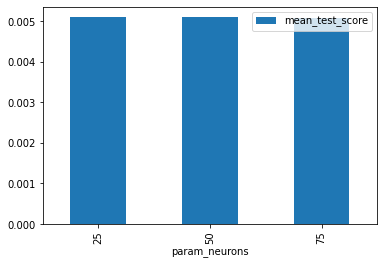

In [0]:
show_grid_search_results(pd.DataFrame(results.cv_results_),['neurons'])

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


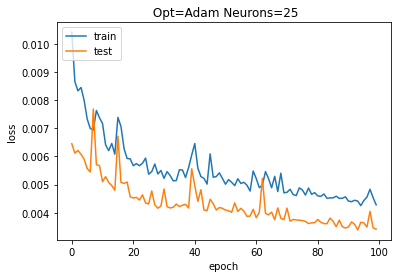

RMSE = 0.015374, MAPE = 115.551291 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


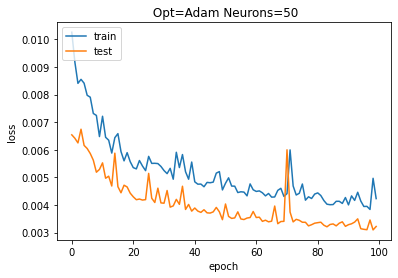

RMSE = 0.015717, MAPE = 102.431590 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


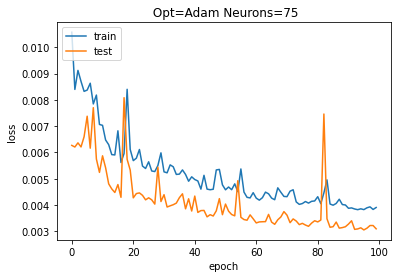

RMSE = 0.014930, MAPE = 88.171841 


In [0]:
# Using NEURONS_LIST = [25, 50, 75]
results = {}
for n in NEURONS_LIST:
  results[n] = train_deep_lstm_ae('Adam', n)

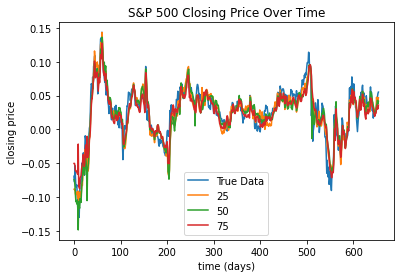

,Metric,25,50,75
0,RMSE,0.01537,0.01572,0.01493
1,MAPE,115.55129,102.43159,88.17184
2,Time (min),33.93872,37.95139,43.42906


In [0]:
get_performance_summary(results, NEURONS_LIST)

#### 2.b. Evaluate performance of each optimizer for best number of neurons.

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


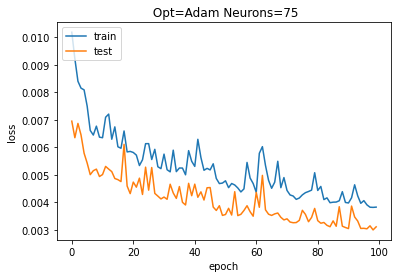

RMSE = 0.014172, MAPE = 94.369972 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


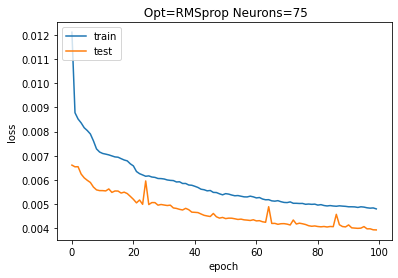

RMSE = 0.015442, MAPE = 102.553075 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


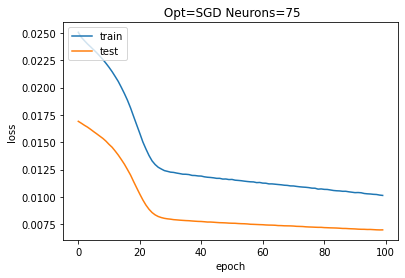

RMSE = 0.034276, MAPE = 92.374334 


In [0]:
results = {}
for opt in OPTIMIZER_LIST:
  results[opt] = train_deep_lstm_ae(opt, 75)

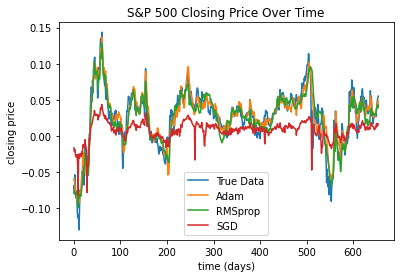

,Metric,Adam,RMSprop,SGD
0,RMSE,0.01417,0.01544,0.03428
1,MAPE,94.36997,102.55308,92.37433
2,Time (min),43.65564,43.34419,43.10764


In [0]:
get_performance_summary(results, OPTIMIZER_LIST)

## BLSTM Autoencoder

1. Implement shallow architecture (two BLSTM layers).
  
  a. Determine optimal number of neurons for BLSTM hidden layers.

  b. Evaluate performance of each optimizer for best number of neurons.

2. Implement deep architecture (four BLSTM layers).
  
  a. Determine optimal number of neurons for BLSTM hidden layers.

  b. Evaluate performance of each optimizer for best number of neurons.

### 1. Implement shallow architecture

In [0]:
# Constants
NEURONS_LIST = [25, 50, 75, 100]
N_EPOCHS = 100

In [0]:
# Helper functions

# Build model
def build_shallow_blstm_ae(optimizer, neurons):
  m = Sequential()
  m.add(Bidirectional(LSTM(neurons, input_shape=(TIME_WINDOW, N_FEATURES), return_sequences=False)))
  m.add(Dropout(0.2))
  m.add(RepeatVector(TIME_WINDOW))
  m.add(Bidirectional(LSTM(neurons, return_sequences=True)))
  m.add(Dropout(0.2))
  m.add(TimeDistributed(Dense(N_FEATURES, activation="linear")))
  
  opt=get_best_optimizer(optimizer)
  m.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
  return m

# Train model
def train_shallow_blstm_ae(opt, neurons):
  blstm_ae = build_shallow_blstm_ae(opt, neurons)
  print('[Model] Training Started')
  print('[Model] %s epochs, %s batch size' % (N_EPOCHS, BATCH_SIZE))
  start_time = time.time()
  history = blstm_ae.fit(x_train, x_train,
        validation_data=(x_test, x_test), 
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
      )
  end_time = time.time()
  print('[Model] Training Completed')
  plot_train_loss(history, " Opt="+opt+" Neurons="+str(neurons))

  # Get predictions
  pred = get_ae_predictions(blstm_ae, x_test)
  err = calculate_error(pred, y_test)
  return [pred, err[0], err[1], end_time-start_time]

#### 1.a. Determine optimal number of neurons for BLSTM layer. Only Adam optimizer is used.

In [0]:
# Grid search 

start_time = time.time()
# Create model
model = KerasRegressor(build_fn=build_shallow_blstm_ae, optimizer='Adam', epochs=100, batch_size=BATCH_SIZE, verbose=1)
# Grid search parameters
param_grid = dict(neurons=NEURONS_LIST)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,  
                    cv=TimeSeriesSplit(n_splits=5)
                    )
results = grid.fit(x_train, x_train)
end_time = time.time()

print("Grid search time: %f min" % ((end_time-start_time)/60))

Grid search time: 282.900246 min


,param_neurons,mean_test_score,std_test_score,mean_score_time
0,25,0.004975,0.001689,9.245716
1,50,0.004337,0.001664,10.465553
2,75,0.004011,0.001524,11.144907
3,100,0.003683,0.001349,12.575767


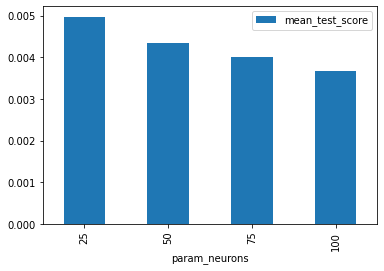

In [0]:
show_grid_search_results(pd.DataFrame(results.cv_results_),['neurons'])

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


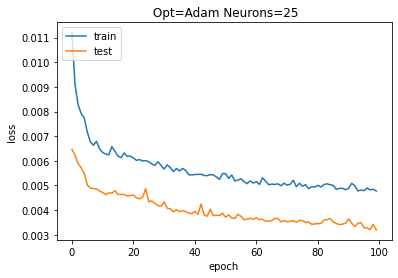

RMSE = 0.015789, MAPE = 108.075346 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


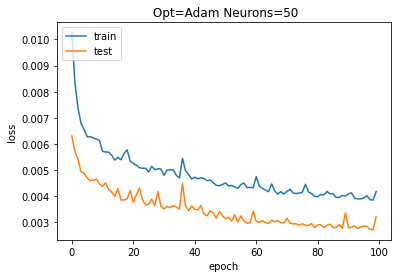

RMSE = 0.015863, MAPE = 92.384645 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


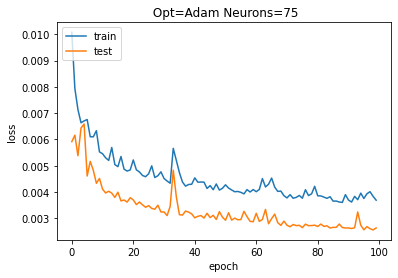

RMSE = 0.014224, MAPE = 89.487405 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


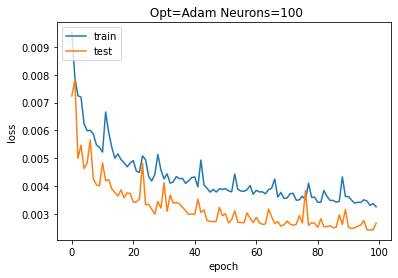

RMSE = 0.013975, MAPE = 81.460296 


In [0]:
# Using NEURONS_LIST = [25, 50, 75, 100]
results = {}
for n in NEURONS_LIST:
  results[n] = train_shallow_blstm_ae('Adam', n)

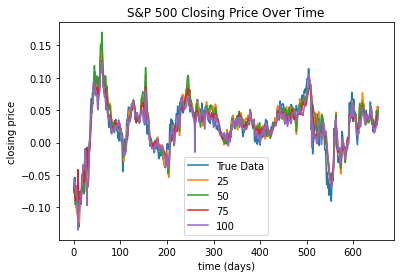

,Metric,25,50,75,100
0,RMSE,0.01579,0.01586,0.01422,0.01397
1,MAPE,108.07535,92.38465,89.48741,81.46030
2,Time (min),21.34779,27.13167,34.67993,45.08106


In [0]:
get_performance_summary(results, NEURONS_LIST)

#### 1.b. Evaluate performance of each optimizer for best number of neurons.

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


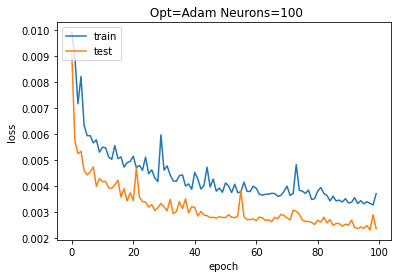

RMSE = 0.013969, MAPE = 70.654970 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


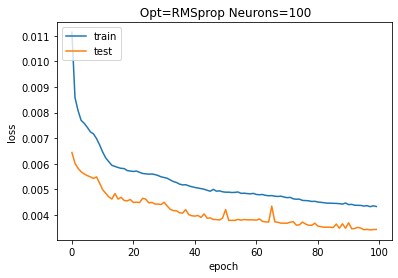

RMSE = 0.014111, MAPE = 95.666630 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


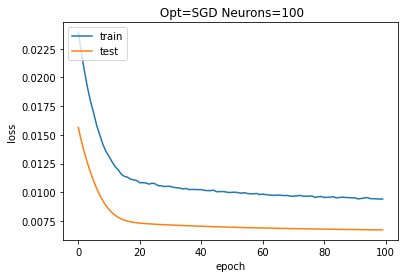

RMSE = 0.032045, MAPE = 86.546117 


In [0]:
results = {}
for opt in OPTIMIZER_LIST:
  results[opt] = train_shallow_blstm_ae(opt, 100)

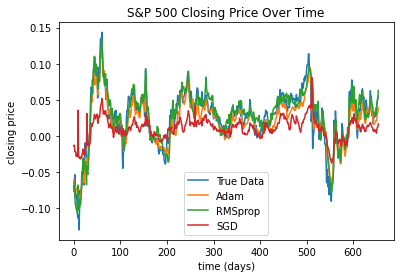

,Metric,Adam,RMSprop,SGD
0,RMSE,0.01397,0.01411,0.03204
1,MAPE,70.65497,95.66663,86.54612
2,Time (min),44.72592,43.74166,38.67274


In [0]:
get_performance_summary(results, OPTIMIZER_LIST)

### 2. Implement deep architecture

In [0]:
# Constants
NEURONS_LIST = [25, 50, 75]
N_EPOCHS = 100

In [0]:
def build_deep_blstm_ae(optimizer, neurons):
  m = Sequential()
  m.add(LSTM(100, input_shape=(TIME_WINDOW, N_FEATURES), return_sequences=True))
  m.add(Dropout(0.2))
  m.add(LSTM(neurons, return_sequences=False))
  m.add(RepeatVector(TIME_WINDOW))
  m.add(LSTM(neurons, return_sequences=True))
  m.add(LSTM(100, return_sequences=True))
  m.add(Dropout(0.2))
  m.add(TimeDistributed(Dense(N_FEATURES, activation="linear")))
  
  opt=get_best_optimizer(optimizer)
  m.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
  return m

# Train model
def train_deep_blstm_ae(opt, neurons):
  blstm_ae = build_deep_blstm_ae(opt, neurons)
  start_time = time.time()
  print('[Model] Training Started')
  print('[Model] %s epochs, %s batch size' % (N_EPOCHS, BATCH_SIZE))
  start_time = time.time()
  history = blstm_ae.fit(x_train, x_train,
        validation_data=(x_test, x_test), 
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
      )
  end_time = time.time()
  print('[Model] Training Completed')
  plot_train_loss(history, " Opt="+opt+" Neurons="+str(neurons))

  # Get predictions
  pred = get_ae_predictions(blstm_ae, x_test)
  err = calculate_error(pred, y_test)
  return [pred, err[0], err[1], end_time-start_time]

2.a. Determine optimal number of neurons for BLSTM layer. Only Adam optimizer is used.

In [0]:
# Grid search 

start_time = time.time()
# Create model
model = KerasRegressor(build_fn=build_deep_blstm_ae, optimizer='Adam', epochs=100, batch_size=BATCH_SIZE, verbose=1)
# Grid search parameters
param_grid = dict(neurons=NEURONS_LIST)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,  
                    cv=TimeSeriesSplit(n_splits=5)
                    )
results = grid.fit(x_train, x_train)
end_time = time.time()

print("Grid search time: %f min" % ((end_time-start_time)/60))

,param_neurons,mean_test_score,std_test_score,mean_score_time
0,25,0.005020,0.001799,6.466082
1,50,0.004796,0.001969,7.237960
2,75,0.004817,0.001828,8.273328


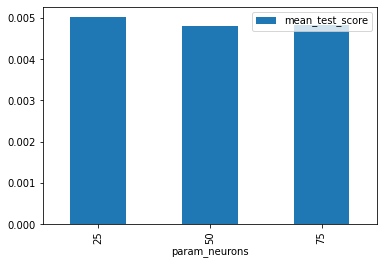

In [0]:
show_grid_search_results(pd.DataFrame(results.cv_results_),['neurons'])

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


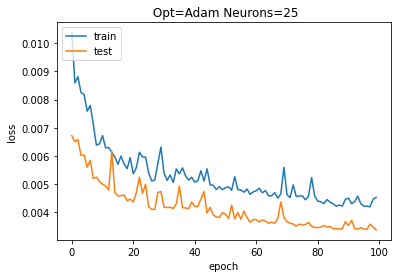

RMSE = 0.016144, MAPE = 97.416928 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


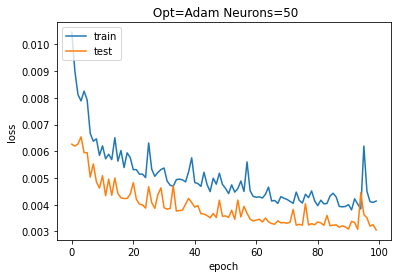

RMSE = 0.017553, MAPE = 109.742131 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


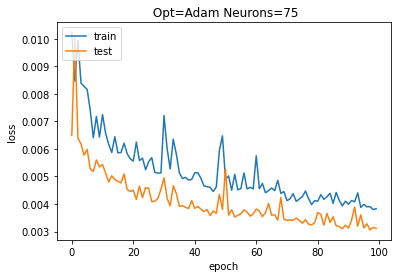

RMSE = 0.015120, MAPE = 88.149534 


In [0]:
# Using NEURONS_LIST = [25, 50, 75]
results = {}
for n in NEURONS_LIST:
  results[n] = train_deep_blstm_ae('Adam', n)

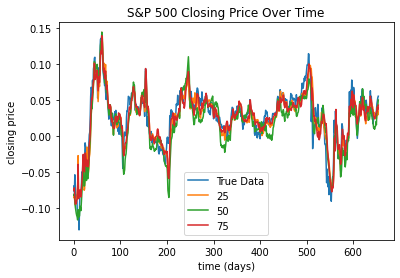

,Metric,25,50,75
0,RMSE,0.01661,0.01891,0.01486
1,MAPE,104.02433,125.43761,94.98748
2,Time (min),33.48474,37.23657,42.47368


In [0]:
get_performance_summary(results, NEURONS_LIST)

#### 2.b. Evaluate performance of each optimizer for best number of neurons.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

[Model] Training Started
[Model] 100 epochs, 32 batch size
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








[Model] Training Completed


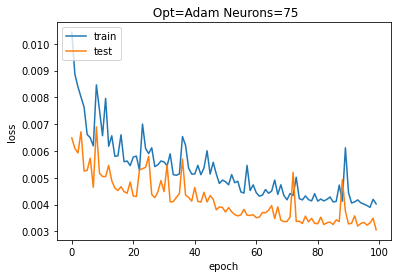

RMSE = 0.014773, MAPE = 92.440218 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


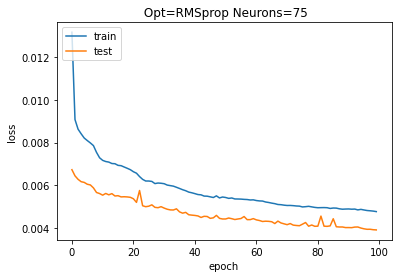

RMSE = 0.014578, MAPE = 95.978169 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


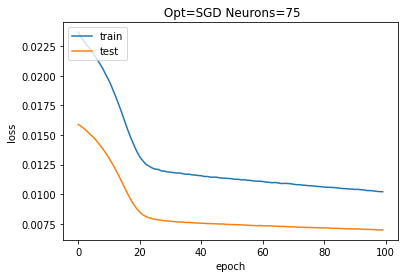

RMSE = 0.037499, MAPE = 99.365754 


In [0]:
results = {}
for opt in OPTIMIZER_LIST:
  results[opt] = train_deep_blstm_ae(opt, 75)

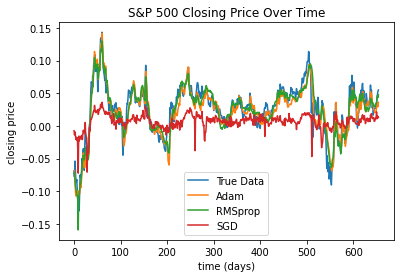

,Metric,Adam,RMSprop,SGD
0,RMSE,0.01477,0.01458,0.03750
1,MAPE,92.44022,95.97817,99.36575
2,Time (min),42.47589,42.51026,43.25428


In [0]:
get_performance_summary(results, OPTIMIZER_LIST)

## CNN-LSTM Architecture

1. Implement CNN-LSTM architecture.
  
  a. Determine optimal filters and kernel size for CNN layers.

  b. Evaluate performance of each optimizer using best filters and kernel size.

### 1. Implement CNN-LSTM architecture.

In [0]:
# Constants
FILTERS_LIST = [5, 10, 25, 50, 75, 100]
KERNELS_LIST = [1, 3, 5, 10]
N_EPOCHS = 100

In [0]:
# Reshape data for use with Conv1D layers
x_train_cnn = x_train.reshape((x_train.shape[0], 1, TIME_WINDOW, N_FEATURES))
x_test_cnn = x_test.reshape((x_test.shape[0], 1, TIME_WINDOW, N_FEATURES))

In [0]:
def build_cnn_lstm_model(optimizer, filters, kernels):
  m = Sequential()
  m.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernels, activation='relu', padding='causal'), 
                        input_shape=(None, TIME_WINDOW, N_FEATURES)))
  m.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernels, activation='relu', padding='causal')))
  m.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  m.add(TimeDistributed(Flatten()))
  m.add(LSTM(100))
  m.add(Dropout(0.2))
  m.add(Dense(1, activation="linear"))
  
  opt=get_best_optimizer(optimizer)
  m.compile(loss='MSE', optimizer=opt, metrics=['MSE'])
  return m

# Train model
def train_cnn_lstm(opt, filters, kernels):
  cnn_lstm = build_cnn_lstm_model(opt, filters, kernels)
  print('[Model] Training Started')
  print('[Model] %s epochs, %s batch size' % (N_EPOCHS, BATCH_SIZE))
  start_time = time.time()
  history = cnn_lstm.fit(x_train_cnn, y_train,
        validation_data=(x_test_cnn, y_test), 
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
      )
  end_time = time.time()
  print('[Model] Training Completed')
  plot_train_loss(history, " Opt="+opt+" Filters="+str(filters)+" Kernels="+str(kernels))

  # Get predictions
  pred = get_predictions(cnn_lstm, x_test_cnn)
  err = calculate_error(pred, y_test)
  return [pred, err[0], err[1], end_time-start_time]

#### 1.a. Determine optimal filters and kernel size for CNN layer. Only Adam optimizer is used.

In [0]:
# Grid search 

start_time = time.time()
# Create model
model = KerasRegressor(build_fn=build_cnn_lstm_model, optimizer='Adam', epochs=100, batch_size=BATCH_SIZE, verbose=0)
# Grid search parameters
param_grid = dict(filters=FILTERS_LIST, kernels=KERNELS_LIST)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,  
                    cv=TimeSeriesSplit(n_splits=5)
                    )
results = grid.fit(x_train_cnn, y_train)
end_time = time.time()

print("Grid search time: %f min" % ((end_time-start_time)/60))

Grid search time: 344.392356 min


In [0]:
show_grid_search_results(pd.DataFrame(results.cv_results_),['filters','kernels'])

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


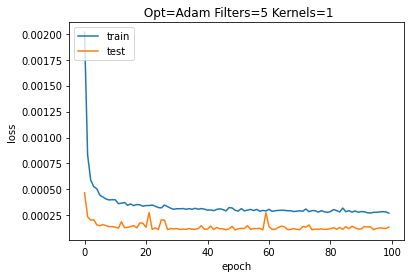

RMSE = 0.011726, MAPE = 72.666637 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


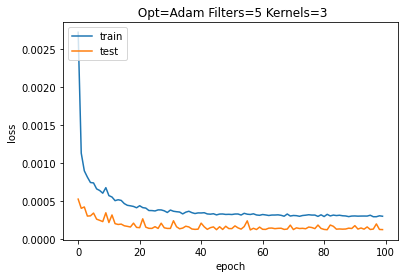

RMSE = 0.011033, MAPE = 70.692912 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


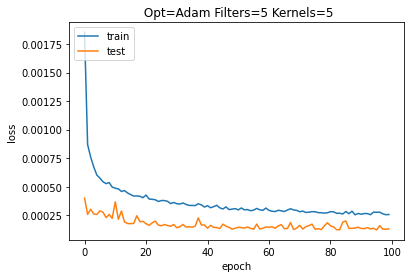

RMSE = 0.011465, MAPE = 74.953793 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


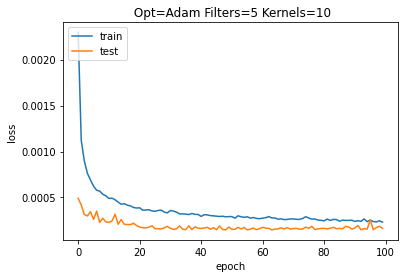

RMSE = 0.012832, MAPE = 78.631208 


In [0]:
# Using KERNELS_LIST = [1, 3, 5, 10], and filters=5
results = {}
for n in KERNELS_LIST:
  results[n] = train_cnn_lstm('Adam', 5, n)

In [0]:
get_performance_summary(results, KERNELS_LIST)

  #### 1.b. Evaluate performance of each optimizer using best filters and kernel size.

[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


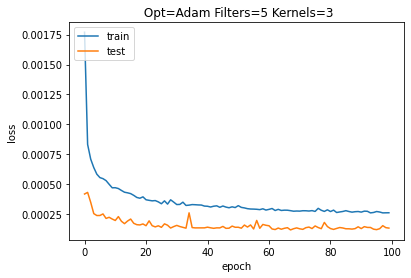

RMSE = 0.011473, MAPE = 66.163888 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


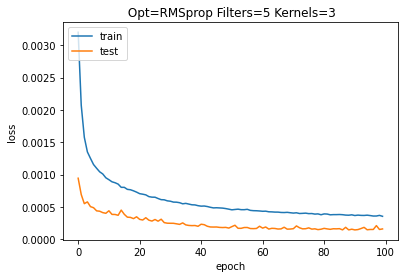

RMSE = 0.012581, MAPE = 68.824966 
[Model] Training Started
[Model] 100 epochs, 32 batch size
[Model] Training Completed


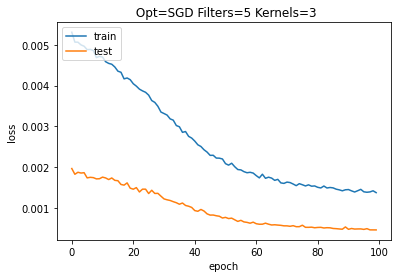

RMSE = 0.021505, MAPE = 138.374864 


In [0]:
results = {}
for opt in OPTIMIZER_LIST:
  results[opt] = train_cnn_lstm(opt, 5, 3)

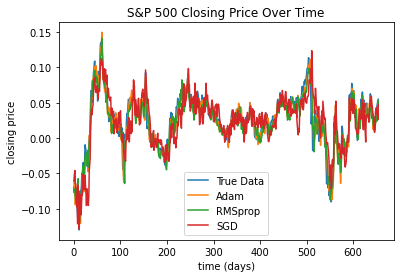

,Metric,Adam,RMSprop,SGD
0,RMSE,0.01147,0.01258,0.02151
1,MAPE,66.16389,68.82497,138.37486
2,Time (min),2.78845,2.78762,2.65141


In [0]:
get_performance_summary(results, OPTIMIZER_LIST)